# Esempio calcolo SD su fantoccio e immagine reale - Notebook 1.6

Import delle librerie necessarie per la simulazione.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pydicom

## Stima SD su immagine simulata. 

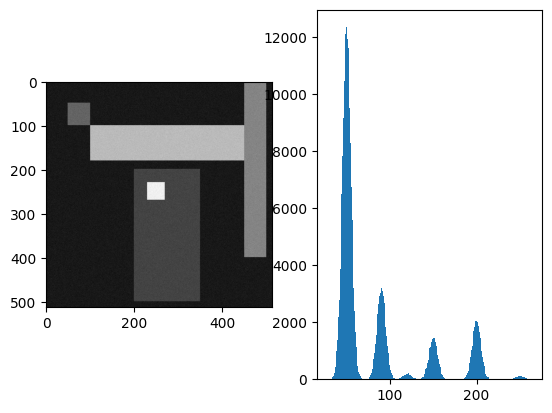

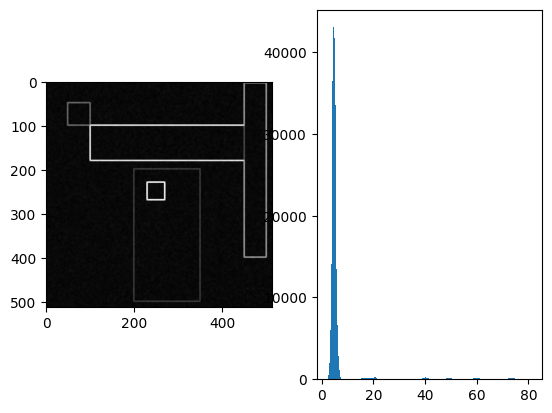

Assigned sigma:  5
Sigma Mean:  6.503379770313196
Sigma Median:  4.853447826563725
Sigma Hist:  4.520810377610957


In [11]:
# create ideal image with 6 patterns
dim = 512
image = np.zeros([dim,dim])
image[:,:] = 50
image[49:100, 49:100] = 120
image[100:180, 100:449] = 200
image[199:499, 199:349] = 90
image[229:269, 229:269] = 250
image[4:399, 449:499] = 150

# add gaussian noise
sigma = 5
imageN = image + sigma*np.random.randn(dim,dim)

# histogram
counts, bins = np.histogram(imageN, bins = 256)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imageN, cmap = 'gray')
ax[1].hist(bins[:-1], bins, weights=counts)

# get map of standard deviation
imageF = ndi.generic_filter(imageN, np.std, size = 5)
countsF, binsF = np.histogram(imageF, bins = 256)

fig, ax = plt.subplots(1,2)
ax[0].imshow(imageF, cmap = 'gray')
ax[1].hist(binsF[:-1], binsF, weights=countsF)

# print estimated values for SD
sigmaMean = np.mean(imageF, None)
sigmaMedian = np.median(imageF, None)
id = np.argmax(countsF)
sigmaMax = binsF[id]
plt.show()

print("Assigned sigma: ",sigma)
print("Sigma Mean: ",sigmaMean)
print("Sigma Median: ",sigmaMedian)
print("Sigma Hist: ",sigmaMax)


## Stima SD su immagine DICOM. 

Patient ID I Test firb pet-MRI


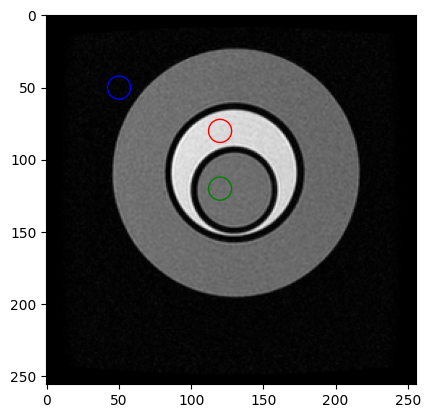

Stima basata su ROI:
Sigma Oil:  14.247686582736174
Sigma Water:  12.884378713050324
Sigma Background:  9.489095224875806
Sigma Background corrected:  14.48035931316048


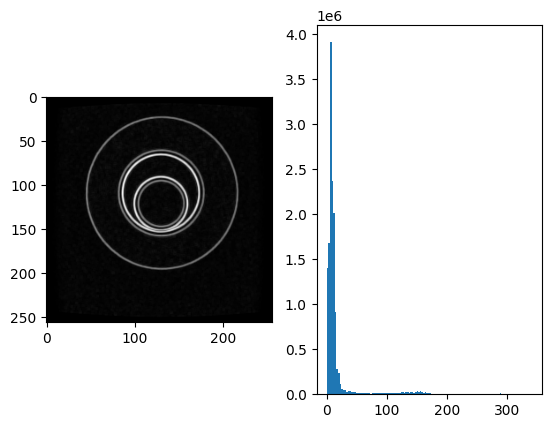

stima basata sulla mappa di SD:
Sigma Mean:  19.34662833727554
Sigma Median:  9.0
Sigma Hist:  5.34375
stima basata sulla mappa di SD utilizzando solo le parti ad alto valore di SD:
Sigma Mean:  55.81278083913939
Sigma Median:  13.0
Sigma Hist:  8.859375


In [12]:
ds = pydicom.dcmread('../data/phantom.dcm')
print("Patient ID", ds.PatientID)

I = ds.pixel_array

nz = np.where(I != 0)[0]

# ROI based analysis
centerO = (120,80)
centerW = (120,120)
centerB = (50,50)
radius = 8

fig, ax = plt.subplots()
ax.imshow(I, cmap = 'gray')
circleO = plt.Circle(centerO, radius, color = 'r', fill = False)
ax.add_patch(circleO)
circleO = plt.Circle(centerW, radius, color = 'g', fill = False)
ax.add_patch(circleO)
circleO = plt.Circle(centerB, radius, color = 'b', fill = False)
ax.add_patch(circleO)

x, y = np.meshgrid(np.arange(ds.Columns), np.arange(ds.Rows))
maskO = (x - centerO[0])**2 + (y - centerO[1])**2 <= radius**2
maskW = (x - centerW[0])**2 + (y - centerW[1])**2 <= radius**2
maskB = (x - centerB[0])**2 + (y - centerB[1])**2 <= radius**2

id = np.where(maskO != 0)
stdO = np.std(I[id], None)

id = np.where(maskW != 0)
stdW = np.std(I[id], None)

id = np.where(maskB != 0)
stdB = np.std(I[id], None)

plt.show()
print("Stima basata su ROI:")
print("Sigma Oil: ",stdO)
print("Sigma Water: ",stdW)
print("Sigma Background: ",stdB)
print("Sigma Background corrected: ",stdB*1.526)

# histogram based analysis
sdmap = ndi.generic_filter(I, np.std, size = 3)
counts, bins = np.histogram(sdmap[nz], bins = 128)

fig, ax = plt.subplots(1,2)
ax[0].imshow(sdmap, cmap = 'gray')
ax[1].hist(bins[:-1], bins, weights=counts)

sigmaMean = np.mean(sdmap[nz], None)
sigmaMedian = np.median(sdmap[nz], None)
id = np.argmax(counts)
sigmaMax = bins[id]
plt.show()
print("stima basata sulla mappa di SD:")
print("Sigma Mean: ",sigmaMean)
print("Sigma Median: ",sigmaMedian)
print("Sigma Hist: ",sigmaMax)


# use only high signal part of the data
nHigh = np.where(I>100)[0]
sdmap = ndi.generic_filter(I, np.std, size = 9)
counts, bins = np.histogram(sdmap[nHigh], bins = 128)

sigmaMean = np.mean(sdmap[nHigh], None)
sigmaMedian = np.median(sdmap[nHigh], None)
id = np.argmax(counts)
sigmaMax = bins[id]
plt.show()

print("stima basata sulla mappa di SD utilizzando solo le parti ad alto valore di SD:")
print("Sigma Mean: ",sigmaMean)
print("Sigma Median: ",sigmaMedian)
print("Sigma Hist: ",sigmaMax)
